# Time variant filtering

In contrast to the (linear) time invariant filter, (linear) time varint filter in this project assumes that the filter coefficients are changing across time.

In such a case, for one input signal, filter coefficients of a time variant filter must be formulated as 2D matrix, in which one dimension denotes the filter length and the other dimension denotes the time index.

Since the filter coefficients are time varying, we assume that the coefficients are provided externally, rather than stored as part of the network weights. Therefore, a time variant filter requires two input: the filter coefficients and the input signal(s).

Implementation of time variant filtering then becomes straightforward: we just need to consider how to convolute the two inputs.

### 1. Module definition

Here is a simple implementation (which may not be efficient though). It is based on definition of convolution.

It is slow because of the *for loop*; but it conduct filtering of all time steps in parallel.

In [3]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func
import sys

class TimeVariantFiltering(torch_nn.Module):
    """ TimeVariantFiltering
    Given sequences of filter coefficients and a signal, do filtering
    
    Initialization: TimeVariantFiltering()
    Forward: output = forward(self, signal, filter_coef)
    
        Filter_coefs: (batchsize, signal_length, filter_order = K)
        
                      (n, m, :) is the filter coefficients for the m-th 
                      time step for n-th tensor in the batch
                      
        Signal:       (batchsize, signal_length, dim)
        
        Output:       (batchsize, signal_length, dim)
    
    
    Filtering is conducted for d \in [0, dim), assuming they use the same 
    time-variant filter.
    
    For time invariant case, given signal [x_1, ..., x_N], filter [a_1, ..., a_K]
    we get output 
                    [y_1, y_2, y_3, ..., y_N, *, * ... *]
            = a_1 * [x_1, x_2, x_3, ..., x_N,   0, ...,   0]
            + a_2 * [  0, x_1, x_2, x_3, ..., x_N,   0, ...,  0]
            + a_3 * [  0,   0, x_1, x_2, x_3, ..., x_N, 0, ...,  0]
            + ...
    
    For time variant casse, given signal [x_1, ..., x_N], filter matrix 
    [[a_{1,1}, ..., a_{K,1}], [a_{1,2}, ..., a_{K,2}], ...], we get output
    
                    y_1,                 y_2,              y_3,    
            = a_{1,1} * x_1  = a_{1,2} * x_2   = a_{1,3} * x_3
            + a_{2,1} *   0  + a_{2,2} * x_1   + a_{2,3} * x_2
            + a_{3,1} *   0  + a_{3,2} *   0   + a_{3,3} * x_1
            + ...            + ...             + ...
    
    """
    def __init__(self):
        super(TimeVariantFiltering, self).__init__()
    
    def forward(self, signal, f_coef):
        """ 
        """
        # signal length
        signal_l = signal.shape[1]
        # order of the time varint filter
        order_k = f_coef.shape[-1]
        
        # pad to signal (batchsize, signal_length + filter_order-1, dim)
        padded_signal = torch_nn_func.pad(signal, (0, 0, 0, order_k - 1))
        
        output = torch.zeros_like(signal)
        # roll and weighted sum, only take [0:signal_length]
        for k in range(order_k):
            output += torch.roll(padded_signal, k, dims=1)[:, 0:signal_l, :] \
                      * f_coef[:, :, k:k+1] 
        return output
    

### 2. Simple example

Here we show the time-variant filtering without using the Module wrapper

In [17]:
# input signal
# make it a batch (batchsize=1, length=4, dim=1)
data = torch.arange(1.0, 5.0, 1).unsqueeze(0).unsqueeze(2)

# filter coefficients
# make it a batch (batchsize=1, length=4, order=3)
coef = [[1, -0.5, -0.5], [1, -0.9, 0], [1, 0, -0.5], [0.3, 0.3, 0.3]]
coef = torch.tensor(coef).unsqueeze(0)

# signal length
signal_l = data.shape[1]
# order of the time varint filter
order_k = coef.shape[-1]

# do filter
l_tv_filter = TimeVariantFiltering()
output = l_tv_filter(data, coef)


(<Figure size 144x36 with 1 Axes>,
 [<matplotlib.axes._axes.Axes at 0x7fddbd39b4c0>])

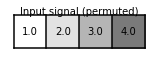

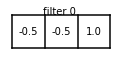

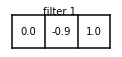

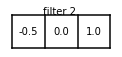

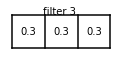

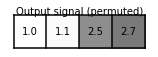

In [20]:
import plot_lib
plot_lib.plot_tensor(data.permute(0, 2, 1), color_on_value=True, title="Input signal (permuted)")

# for plotting we flip the filter coefficients
for time_idx in range(coef.shape[1]):
    plot_lib.plot_tensor(torch.flip(coef[:, time_idx:time_idx+1, ], dims=[2]), 
                         color_on_value=False, colorgrad_x=False, colorgrad_y=False,
                         colormap="Greys", alpha=1.0, title = 'filter %d ' % (time_idx))

plot_lib.plot_tensor(output.permute(0, 2, 1), color_on_value=True, title="Output signal (permuted)")

### 3. Plot the operation step by stpe

Here we plot the operation in the Module step by step

(<Figure size 36x144 with 1 Axes>,
 [<matplotlib.axes._axes.Axes at 0x7fddc0711ac0>])

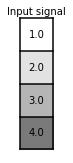

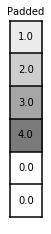

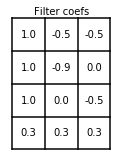

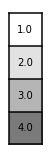

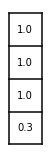

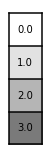

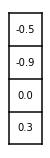

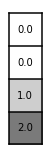

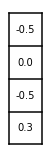

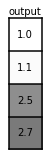

In [34]:
# input signal
# make it a batch (batchsize=1, length=4, dim=1)
data = torch.arange(1.0, 5.0, 1).unsqueeze(0).unsqueeze(2)

# filter coefficients
# make it a batch (batchsize=1, length=4, order=3)
coef = [[1, -0.5, -0.5], [1, -0.9, 0], [1, 0, -0.5], [0.3, 0.3, 0.3]]
coef = torch.tensor(coef).unsqueeze(0)

# signal length
signal_l = data.shape[1]
# order of the time varint filter
order_k = coef.shape[-1]

signal = data
# do filter
# pad to signal (batchsize, signal_length + filter_order-1, dim)
padded_signal = torch_nn_func.pad(signal, (0, 0, 0, order_k - 1))
plot_lib.plot_tensor(signal, color_on_value=True, title="Input signal")
plot_lib.plot_tensor(padded_signal, color_on_value=True, title="Padded")
plot_lib.plot_tensor(coef, color_on_value=False, colorgrad_x=False, colorgrad_y=False, title="Filter coefs")

output = torch.zeros_like(signal)
# roll and weighted sum, only take [0:signal_length]
for k in range(order_k):
    output += torch.roll(padded_signal, k, dims=1)[:, 0:signal_l, :] * coef[:, :, k:k+1] 
    plot_lib.plot_tensor(torch.roll(padded_signal, k, dims=1)[:, 0:signal_l, :], 
                         color_on_value=True)
    plot_lib.plot_tensor(coef[:, :, k:k+1], 
                         color_on_value=False, colorgrad_x=False, colorgrad_y=False)
plot_lib.plot_tensor(output, color_on_value=True, title="output")

### 4. Example for signal processing

Text(0.5, 0, 'filter length')

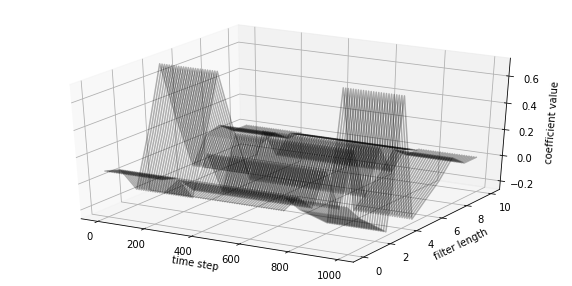

In [41]:
from scipy import signal as sci_signal
import scipy.fft
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)


# Prepare input signal
signal_length = 1000
signal_dim = 2
batch_size = 2

signal_input = torch.randn(batch_size, signal_length, signal_dim, requires_grad = False)


# Prepare a time-variant filter based on the following filter coefficients
# The filter coefficients should be in shape [batch_size, signal_length, filter_order]
# In this example, different batches use the same filter coefs 
lp_v = torch.tensor([0.08538414199291068, 0.04920229475534168, -0.1470178606967731, 0.24737764593887432, 0.7103067853166558, 0.24737764593887432, -0.1470178606967731, 0.04920229475534168, 0.08538414199291068])
lp_u = torch.tensor([0.00936455546502, 0.0416254862901, 0.0878313219556, 0.146086321198, 0.192602581136, 0.211221591449, 0.192602581136, 0.146086321198, 0.0878313219556, 0.0416254862901, 0.00936455546502])
hp_v = torch.tensor([-0.00936455546502148, 0.04162548629009957, -0.08783132195564508, 0.1460863211980122, -0.19260258113649556,  0.21122159144894015, -0.19260258113649556, 0.1460863211980122, -0.08783132195564508, 0.04162548629009957, -0.00936455546502148])
hp_u = torch.tensor([0.0853841419929, -0.0492022947553, -0.147017860697, -0.247377645939, 0.710306785317, -0.247377645939, -0.147017860697, -0.0492022947553, 0.0853841419929])

# initialize buffer
tv_filter_coefs = torch.zeros(batch_size, signal_length, max([len(lp_v), len(lp_u), len(hp_v), len(hp_u)]))
# assume the time-variant filter changes very signal_length / 4 time steps
tv_filter_coefs[:, signal_length//4*0:signal_length//4*1, 0:len(lp_v)] = lp_v
tv_filter_coefs[:, signal_length//4*1:signal_length//4*3, 0:len(hp_v)] = hp_v
#tv_filter_coefs[:, signal_length//4*2:signal_length//4*3, 0:len(lp_u)] = lp_u
tv_filter_coefs[:, signal_length//4*3:, 0:len(hp_u)] = hp_u

fig = plt.figure()
ax = fig.gca(projection='3d')
for idx in range(signal_length)[::10]:
    y = np.arange(tv_filter_coefs.shape[-1])
    x = np.ones([tv_filter_coefs.shape[-1]]) * idx
    z = tv_filter_coefs[0, idx, :]
    ax.plot(x, y, z, 'k', alpha=0.3)
ax.set_xlabel('time step')
ax.set_zlabel('coefficient value')
ax.set_ylabel('filter length')


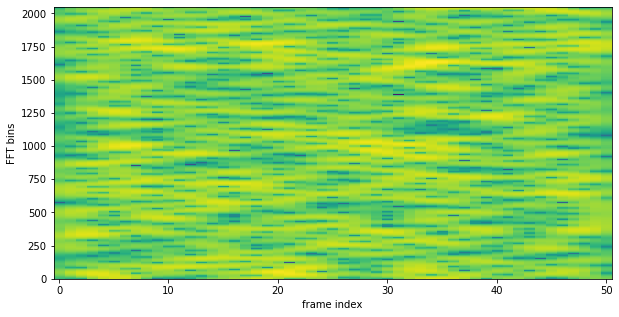

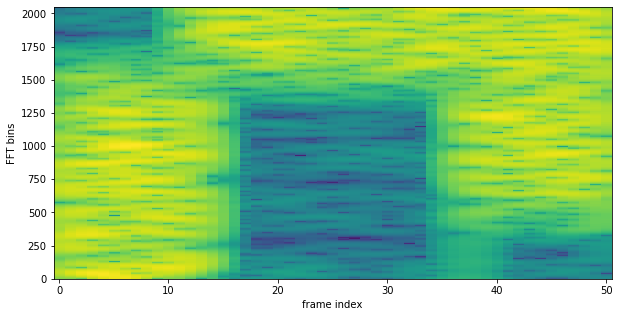

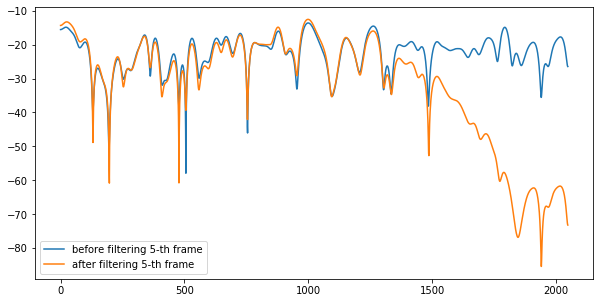

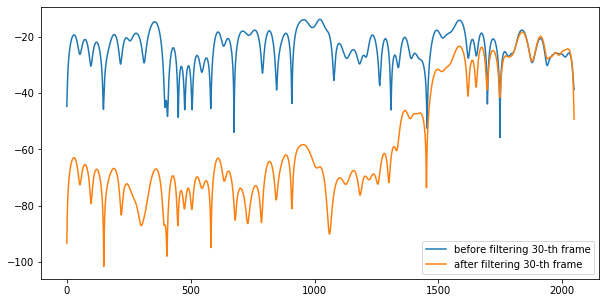

In [42]:
# initialize. the TimeVariantFiltering Layer and try filtering
# do filering
tv_layer = TimeVariantFiltering()
signal_output = tv_layer(signal_input, tv_filter_coefs)


# Plot 
# let's try to plot the spectrogram
# let's analysis only one signal
import tool_lib
signal_in_examine = signal_input[0, :, 0]
signal_out_examine = signal_output[0, :, 0]

spec_in_examine = tool_lib.spec_amplitude(signal_in_examine, frame_length=200, frame_shift=20)
spec_out_examine = tool_lib.spec_amplitude(signal_out_examine, frame_length=200, frame_shift=20)

plt.figure()
plt.imshow(spec_in_examine, aspect='auto', origin='lower')
plt.xlabel('frame index')
plt.ylabel('FFT bins')
plt.figure()
plt.imshow(spec_out_examine, aspect='auto', origin='lower')
plt.xlabel('frame index')
plt.ylabel('FFT bins')

plt.figure()
frame_idx = 5
plt.plot(spec_in_examine[:, frame_idx])
plt.plot(spec_out_examine[:, frame_idx])
plt.legend(["before filtering %d-th frame" % (frame_idx), "after filtering %d-th frame" % (frame_idx)])

plt.figure()
frame_idx = 30
plt.plot(spec_in_examine[:, frame_idx])
plt.plot(spec_out_examine[:, frame_idx])
plt.legend(["before filtering %d-th frame" % (frame_idx), "after filtering %d-th frame" % (frame_idx)])


(2049, 51)